In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from IPython import display

# Testing the Software Libraries

## Show that we can plot a multivariate Normal distribution

The following code is based on demo code from the [Scipy site](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html)

In [3]:
x, y = np.mgrid[-1:1:.02, -1:1:.02]

In [4]:
coord = np.empty(x.shape + (2,))
coord[:, :, 0] = x
coord[:, :, 1] = y

### Plot a multivariate centered at (0,0)

Covariance matrix was tweaked until we got a small center and all levels to appear on the chart

In [5]:
def get_multivariate_normal(mean, covariance, coord, height=None):
    dist = multivariate_normal(mean, covariance)
    z = dist.pdf(coord)
    if height is not None:
        z = (z / np.max(z)) * height
    return z

In [6]:
def plot_contour(x, y, z, levels=[0, 1, 2, 3, 4, 5]):
    cs = contour(x, y, z, colors='b', levels=levels)
    clabel(cs, fmt="%d")

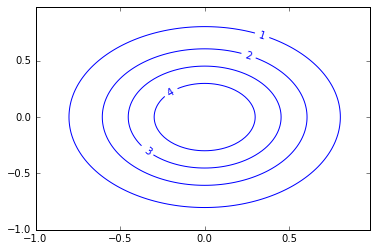

In [7]:
z = get_multivariate_normal((0, 0), .2, coord, height=5)
plot_contour(x, y, z)

### Plot a multivariate off center (around (0.5, 0.5))

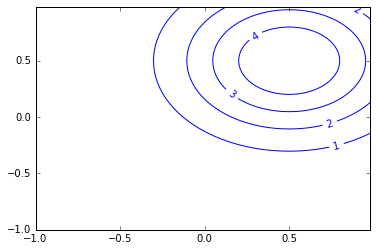

In [8]:
z = get_multivariate_normal((0.5, 0.5), .2, coord, height=5)
plot_contour(x, y, z)

# Run Steepest Ascent

### Helper Methods

#### The Model

Gradient computed as follows:
$\nabla(a_1x + a_2y + a_3x^2 + a_4y^2 + a_5xy + a_6) = $
$\begin{bmatrix} a_1 + 2a_3x + a_5y \\ a_2 + 2a_4y + a_5x \end{bmatrix}$

In [248]:
class LeastSquares(object):
    
    def __init__(self):
        self.coeff = None
    
    def featurize(self, X):
        features = []
        for row in X:
            x, y = row
            features.append([x, y, x*x, y*y, x*y, 1])
        return np.array(features)

    @property
    def initialized(self):
        return self.coeff is not None
    
    def fit(self, X, predictions):  
        feat = self.featurize(X)
        self.coeff = linalg.lstsq(feat, predictions)[0] 
    
    def predict(self, X):
        predictions = []
        feat = self.featurize(X)
        for row in feat:
            prediction = row.dot(self.coeff)
            predictions.append(prediction)
        return np.array(predictions) 
    
    def gradient(self, point):
        x, y = point
        return np.array([
            self.coeff[0] + (2 * self.coeff[2] * x) + (self.coeff[4] * y),
            self.coeff[1] + (2 * self.coeff[3] * y) + (self.coeff[5] * x),
        ])  

In [230]:
def add_element(np_array, el):
    list_ = np_array.tolist()
    list_.append(el)
    return np.array(list_)

#### Plotting / Visualization / User Input

In [211]:
def plot_gaussian():
    x_gauss, y_gauss = np.mgrid[-1:1:.02, -1:1:.02]
    coord = np.empty(x_gauss.shape + (2,))
    coord[:, :, 0] = x_gauss
    coord[:, :, 1] = y_gauss
    z = get_multivariate_normal((0.5, 0.5), .4, coord, height=5)
    plot_contour(x_gauss, y_gauss, z)    

In [232]:
def plot_model(model):
    coord_grid = np.mgrid[-1:1:.02,-1:1:.02]
    model_x, model_y = coord_grid
    model_x_flat = model_x.flatten()
    model_y_flat = model_y.flatten()
    model_coord = np.array(zip(model_x_flat, model_y_flat))
    model_pred = model.predict(model_coord)
    contour(model_x, model_y, model_pred.reshape((100,100)))

In [242]:
def query_rank(index, model):

    # Show the point queried on the current plot
    fig = figure(figsize=(8, 3))
    subplot(1, 2, 1)
    if model.initialized:
        plot_model(model)
    title("Current model")
    
    subplot(1, 2, 2)
    plot_gaussian()
    hold('on')
    plot(X[index][0], X[index][1], 'rx', markersize=20)
    display.display(gcf())
    title("Give a rank to the X")

    # Get rank for the new input point
    print "Enter rank (1-5):",
    return raw_input()

### Running the Algorithm

Start out the algorithm with the four points in the corner

In [250]:
X = np.array([
    [-1, -1],
    [1, -1],
    [-1, 1],
    [1, 1],
])

In [251]:
y = np.empty(0)

In [252]:
model = LeastSquares()

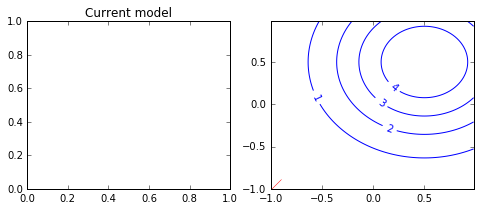

Enter rank (1-5):1


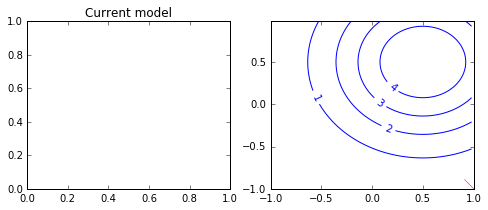

 Enter rank (1-5):1


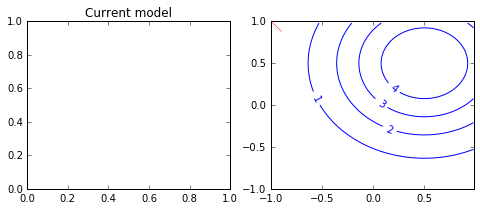

 Enter rank (1-5):1


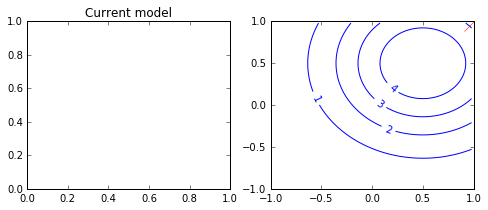

 Enter rank (1-5):2
 [ 0.25  0.25]


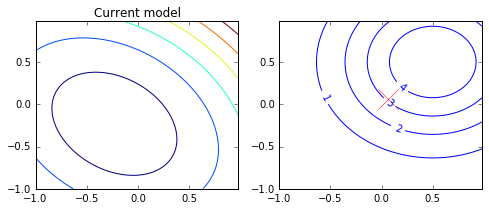

Enter rank (1-5):3
 [ 0.15784314  0.328125  ]


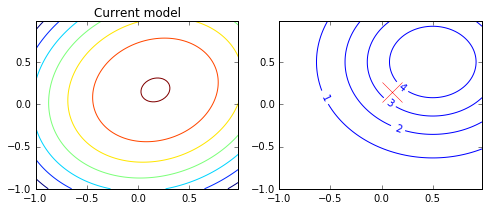

Enter rank (1-5):3
 [ 0.35984753 -0.04969971]


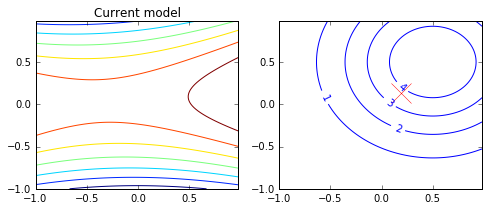

Enter rank (1-5):3
 [-0.11023862  0.63627482]


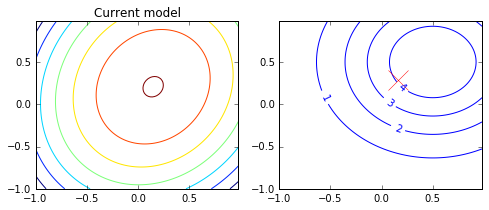

Enter rank (1-5):4
 [-4.65314639  8.54129814]


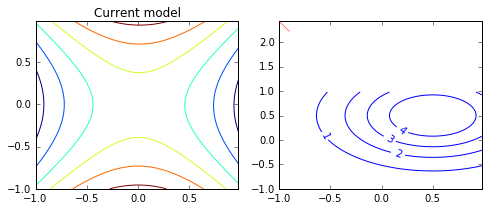

Enter rank (1-5):

In [ ]:
STEP = .25  # Determined by what seems like a small but significant step without causing thrashing
ITERATIONS = 20
current_x = np.array([0, 0])

for i in range(0, ITERATIONS):
    
    # Get values for every unlabeled x-point
    for xi in range(0, X.shape[0]):
        
        if xi >= y.shape[0]:
            newy = query_rank(xi, model)
            y = add_element(y, newy)
    
    model.fit(X, y)
    grad = model.gradient(current_x)
    print grad
    current_x = current_x + grad * STEP
    X = add_element(X, current_x)

We run into an annoying problem here.  When we end up expecting that there's a saddle point (which may be tempting to find if there's some similar measurements in 3 of the 4 corners), then there may be no one maximum but instead unlimited growth in one direction.  We need to limit our model so that this isn't a possibility.  It's probably time to go back to that chapter on second-order approximation in Box & Draper.